[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


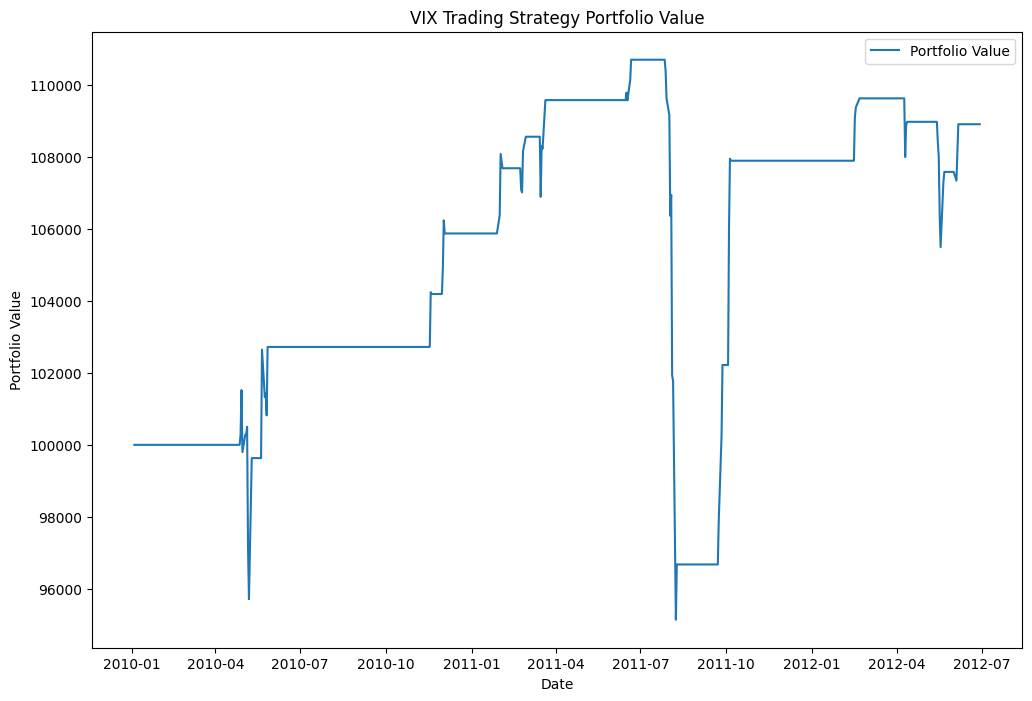

Initial Capital: $100000.00
Final Portfolio Value: $108899.76
Return: 8.90%


In [4]:
# 1. Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# 2. Creating a Function to Load Data
def load_data(start_date, end_date):
    # Load VIX data
    vix = yf.download('^VIX', start=start_date, end=end_date)
    # Load SPY data
    spy = yf.download('SPY', start=start_date, end=end_date)
    
    return vix, spy

# 3. Implementing Strategy
def implement_strategy(vix, spy):
    # Calculate Bollinger Bands for VIX
    vix['20d_MA'] = vix['Close'].rolling(window=20).mean()
    vix['20d_STD'] = vix['Close'].rolling(window=20).std()
    vix['Upper_BB'] = vix['20d_MA'] + (vix['20d_STD'] * 2)
    
    # Identify signal where VIX breaks upper Bollinger Band
    vix['Signal'] = np.where(vix['Close'] > vix['Upper_BB'], 1, 0)
    
    # Merge signals with SPY data
    spy['Signal'] = vix['Signal'].shift(1)  # Use next day's opening price for entry
    
    # Define a function to find exit points
    def find_exit(signal):
        exit_signal = []
        for i in range(len(signal)):
            if signal[i] == 1:
                up_days = 0
                for j in range(i + 1, len(signal)):
                    if spy['Close'][j] > spy['Close'][j - 1]:
                        up_days += 1
                    if up_days == 2:
                        exit_signal.append(j)
                        break
        return exit_signal
    
    # Get exit signals
    exit_points = find_exit(spy['Signal'])
    
    return spy, exit_points

# 4. Backtesting Strategy
def backtest_strategy(spy, exit_points):
    # Initialize variables for backtesting
    initial_capital = 100000.0
    position = 0
    capital = initial_capital
    portfolio = []
    
    for i in range(len(spy)):
        if spy['Signal'][i] == 1 and position == 0:
            # Buy SPY
            position = capital / spy['Open'][i]
            capital = 0
        
        if i in exit_points and position > 0:
            # Sell SPY
            capital = position * spy['Open'][i]
            position = 0
        
        # Record portfolio value
        portfolio.append(capital + position * spy['Close'][i])
    
    # Convert to DataFrame
    portfolio_df = pd.DataFrame({'Portfolio': portfolio}, index=spy.index)
    
    return portfolio_df, initial_capital

# 5. Running the Main Program
def main():
    # Define the test period
    start_date = '2010-01-01'
    end_date = '2012-07-01'
    
    # Load data
    vix, spy = load_data(start_date, end_date)
    
    # Implement strategy
    spy, exit_points = implement_strategy(vix, spy)
    
    # Backtest strategy
    portfolio_df, initial_capital = backtest_strategy(spy, exit_points)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_df.index, portfolio_df['Portfolio'], label='Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('VIX Trading Strategy Portfolio Value')
    plt.legend()
    plt.show()
    
    # Print final portfolio value
    final_value = portfolio_df['Portfolio'].iloc[-1]
    print(f'Initial Capital: ${initial_capital:.2f}')
    print(f'Final Portfolio Value: ${final_value:.2f}')
    print(f'Return: {((final_value - initial_capital) / initial_capital) * 100:.2f}%')

if __name__ == "__main__":
    main()
